In [1]:
from netCDF4 import Dataset
from netCDF4 import num2date
import matplotlib
#matplotlib.use('Agg')  # Use the 'Agg' backend which doesn't require a display
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from scipy import special
from scipy.stats import norm
from scipy.stats import ks_2samp as ks_2samp
import sys

import os
from glob import glob
import cftime
from scipy.spatial import cKDTree
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import matplotlib.colors as mcolors

MODELS = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM','ICTP','KIT','KNMI','UKMO']
MODELS = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM','ICTP','KIT','KNMI','UKMO','JLU']

filename_nonCP = [ \
f'tasmax_EUR-15_NorESM1-ME_historical_r1i1p1_BCCR-WRF381DA_fpsconv-x1n2-v1_day_JJA.nc', \
f'tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CLMcom-CCLM4-8-17_cordex-x0n1-v1_day_JJA.nc', \
f'tasmax_EUR-11_ICHEC-EC-EARTH_historical_r12i1p1_CLMcom-CMCC-CCLM5-0-9_v1_day_JJA.nc', \
f'tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CNRM-ALADIN63_v2_day_JJA.nc', \
f'tasmax_EUR-11_MPI_historical_r1i1p1_COSMO-pompa_5.0_2019.1_day_JJA.nc', \
f'tasmax_EUR-15_SMHI-EC-EARTH_historical_r12_FZJ-IBG3-WRF381CA_v1_day_JJA.nc', \
f'tasmax_ALP-12_ICHEC-EC-EARTH_historical_r12i1p1_HCLIMcom-HCLIM38-ALADIN_v1_day_JJA.nc', \
f'tasmax_EUR-11_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_fpsconv-x2yn1-v1_day_JJA.nc', \
f'tasmax_EUR-11_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_day_JJA.nc', \
f'tasmax_WCE-11_KNMI-EC-EARTH_historical_r14i1p1_KNMI-RACMO23E_v1_day_JJA.nc', \
f'tasmax_EUR-11_MOHC-HadGEM2-ES_historical_r1i1p1_MOHC-HadREM3-GA7-05_v1_day_JJA.nc', \
]

filename_CP = [ \
'tasmax_ALP-3_NorESM1-ME_historical_r1i1p1_BCCR-WRF381DA_fpsconv-x1n2-v1_day_JJA.nc',\
'tasmax_ALP-3_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CLMcom-BTU-CCLM5-0-14_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_ICHEC-EC-EARTH_historical_r12i1p1_CLMcom-CMCC-CCLM5-0-9_x2yn2v1_day_JJA.nc', \
'tasmax_ALP-3_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CNRM-AROME41t1_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_MPI_historical_r1i1p1_COSMO-pompa_5.0_2019.1_day_JJA.nc', \
'tasmax_ALP-3_SMHI-EC-EARTH_historical_r12_FZJ-IBG3-WRF381CA_v1_day_JJA.nc', \
'tasmax_ALP-3_ICHEC-EC-EARTH_historical_r12i1p1_HCLIMcom-HCLIM38-AROME_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-KIT-CCLM5-0-15_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_KNMI-EC-EARTH_historical_r14i1p1_KNMI-HCLIM38h1-AROME_fpsconv-x2yn2-v1_day_JJA.nc', \
'tasmax_ALP-3_HadGEM3-GC3.1-N512_historical_r1i1p1_HadREM3-RA-UM10.1_fpsconv-x0n1-v1_day_JJA.nc', \
'tasmax_ALP-3_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-JLU-CCLM5-0-15_fpsconv-x0n1-v1_day_JJA.nc'\
]


### Plot orography of the FPSCONV domain

In [2]:
file_orog = '/data/cmcc/ls21622/C3S2_413/ETOPO1/ETOPO1_Bed_g_gmt4_crop_small.grd'


### Load and plot observations

In [3]:
OBS_DIR = '/data/cmcc/ls21622/C3S2_413/HadISD/outputs2'

# Initialize an empty list to store DataFrames for each file
all_dataframes = []
count_nan_per_site = []
mask_nan=[]

# Specify the latitude and longitude range
lat_range = slice(40, 50)  # Adjust as needed
lon_range = slice(0, 20)  # Adjust as needed

# Define the time range for the years 1996 to 2005
start_date = '1996-01-01'
end_date = '2005-12-31'
        
# Create an empty list to store DataFrames for each site
site_dfs = []

# Loop through each file in the directory
for filename in os.listdir(f'{OBS_DIR}'):
    if filename.endswith('.nc'):
        # Construct the full path to the file
        file_path = os.path.join(f'{OBS_DIR}/{filename}')
        
        #print(f'{file_path}')
        
        # Open the NetCDF file
        ds = xr.open_dataset(f'{file_path}')
        
        # Extract lon, lat, and elevation (assuming these variables exist in the dataset)
        lon = ds['longitude'].values.item()
        lat = ds['latitude'].values.item()
        elevation = ds['elevation'].values.item()

        # Extract temperature variable
        temperature = ds['temperatures']
        time = ds['time']
        
        if lon_range.start <= lon <= lon_range.stop and lat_range.start <= lat <= lat_range.stop:
            
            # Select the temperature data for the specified time range
            selected_temperature = temperature.sel(time=slice(start_date, end_date))
            selected_time = time.sel(time=slice(start_date, end_date))
            
            # Create a complete hourly calendar for the specified time range
            complete_calendar = pd.date_range(start=start_date, end=end_date, freq='H')
            
            # Identify available time steps and corresponding temperature values
            available_time_steps = pd.to_datetime(selected_time.values)
            available_temperature_values = selected_temperature.values
            
            # Create a DataFrame with the complete calendar
            df_complete_calendar = pd.DataFrame({'time': complete_calendar})
            
            # Merge the complete calendar with the available time steps and temperature values
            df_merged = pd.merge(df_complete_calendar, pd.DataFrame({'time': available_time_steps, 'temperature': available_temperature_values}),
                     on='time', how='left')
            
            # Assuming df_merged has 'time' as a column, convert it to datetime and set it as the index
            df_merged['time'] = pd.to_datetime(df_merged['time'])
            df_merged.set_index('time', inplace=True)

            # Resample to daily frequency and calculate daily mean temperature
            # Set min_count to 12 to require at least 12 non-null values for each day
            #df_daily_max = df_merged.resample('D').max(min_count=12)

            df_daily_max = df_merged.groupby(pd.Grouper(freq='D')).max(min_count=12)
            
            # Reset the index to get 'time' back as a regular column
            df_daily_max.reset_index(inplace=True)
    
            df_daily_max_jja = df_daily_max[(df_daily_max['time'].dt.month >= 6) & (df_daily_max['time'].dt.month <= 8)]
    
            
            # Check the percentage of NaN values in df_daily_max_jja
            percentage_nan_values = df_daily_max_jja['temperature'].isnull().sum() / len(df_daily_max_jja) * 100
            
            # Skip if more than 50% of values are NaN
            if percentage_nan_values > 50:
                print(f"Skipping {filename} due to high percentage of NaN values in JJA: {percentage_nan_values}%")
                continue
        
            # Add additional information to the DataFrame for the first time step only
            df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
            df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
            df_daily_max_jja.loc[df_daily_max_jja.index[0], 'elevation'] = elevation
            df_daily_max_jja.loc[df_daily_max_jja.index[0], 'filename'] = filename
            
            # Append the DataFrame to the list
            all_dataframes.append(df_daily_max_jja)


Skipping hadisd.3.3.1.202310p_19310101-20231101_110750-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_132660-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_135620-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113100-99999.nc due to high percentage of NaN values in JJA: 66.41304347826087%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111270-99999.nc due to high percentage of NaN values in JJA: 81.84782608695652%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161900-99999.nc due to high percentage of NaN values in JJA: 96.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107910-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113800-99999.nc due to high percentage of NaN values in JJA: 65.43478260869566%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112140-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109460-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112040-99999.nc due to high percentage of NaN values in JJA: 74.67391304347825%
Skipping hadisd.3.3.1.202310p_19310101-20231101_118800-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108580-99999.nc due to high percentage of NaN values in JJA: 82.06521739130434%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067350-99999.nc due to high percentage of NaN values in JJA: 56.30434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162640-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110010-99999.nc due to high percentage of NaN values in JJA: 76.95652173913044%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111650-99999.nc due to high percentage of NaN values in JJA: 79.8913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162592-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_134590-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113400-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161380-99999.nc due to high percentage of NaN values in JJA: 53.369565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066050-99999.nc due to high percentage of NaN values in JJA: 52.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110240-99999.nc due to high percentage of NaN values in JJA: 66.73913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110162-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_073820-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111570-99999.nc due to high percentage of NaN values in JJA: 79.8913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107450-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110320-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109480-99999.nc due to high percentage of NaN values in JJA: 96.95652173913044%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066790-99999.nc due to high percentage of NaN values in JJA: 56.30434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_146400-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110220-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_115410-99999.nc due to high percentage of NaN values in JJA: 68.58695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076880-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107550-99999.nc due to high percentage of NaN values in JJA: 53.04347826086957%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108520-99999.nc due to high percentage of NaN values in JJA: 86.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107520-99999.nc due to high percentage of NaN values in JJA: 58.58695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106750-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162600-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066045-99999.nc due to high percentage of NaN values in JJA: 99.89130434782608%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107750-99999.nc due to high percentage of NaN values in JJA: 54.347826086956516%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_130670-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110600-99999.nc due to high percentage of NaN values in JJA: 65.76086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_161290-99999.nc due to high percentage of NaN values in JJA: 96.6304347826087%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_072450-99999.nc due to high percentage of NaN values in JJA: 63.26086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111360-99999.nc due to high percentage of NaN values in JJA: 81.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_142840-99999.nc due to high percentage of NaN values in JJA: 96.84782608695653%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112920-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%
Skipping hadisd.3.3.1.202310p_19310101-20231101_163240-99999.nc due to high percentage of NaN values in JJA: 57.065217391304344%
Skipping hadisd.3.3.1.202310p_19310101-20231101_077680-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076660-99999.nc due to high percentage of NaN values in JJA: 64.13043478260869%
Skipping hadisd.3.3.1.202310p_19310101-20231101_142440-99999.nc due to high percentage of NaN values in JJA: 98.36956521739131%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162890-34113.nc due to high percentage of NaN values in JJA: 90.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110400-99999.nc due to high percentage of NaN values in JJA: 71.73913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162040-99999.nc due to high percentage of NaN values in JJA: 98.69565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107630-99999.nc due to high percentage of NaN values in JJA: 86.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110780-99999.nc due to high percentage of NaN values in JJA: 65.76086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113570-99999.nc due to high percentage of NaN values in JJA: 67.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_109210-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067480-99999.nc due to high percentage of NaN values in JJA: 56.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_130145-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_129300-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162580-99999.nc due to high percentage of NaN values in JJA: 96.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162210-99999.nc due to high percentage of NaN values in JJA: 62.39130434782608%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066210-99999.nc due to high percentage of NaN values in JJA: 52.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162940-99999.nc due to high percentage of NaN values in JJA: 96.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107140-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067050-99999.nc due to high percentage of NaN values in JJA: 56.30434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_109610-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066200-99999.nc due to high percentage of NaN values in JJA: 52.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111820-99999.nc due to high percentage of NaN values in JJA: 64.34782608695652%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_163000-99999.nc due to high percentage of NaN values in JJA: 97.71739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112440-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076530-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113700-99999.nc due to high percentage of NaN values in JJA: 71.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144280-99999.nc due to high percentage of NaN values in JJA: 77.6086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067800-99999.nc due to high percentage of NaN values in JJA: 56.739130434782616%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_145440-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162591-99999.nc due to high percentage of NaN values in JJA: 82.06521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111190-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_119270-99999.nc due to high percentage of NaN values in JJA: 80.21739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_161140-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110180-99999.nc due to high percentage of NaN values in JJA: 65.97826086956522%
Skipping hadisd.3.3.1.202310p_19310101-20231101_133480-99999.nc due to high percentage of NaN values in JJA: 56.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066590-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111700-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142190-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_160400-99999.nc due to high percentage of NaN values in JJA: 53.04347826086957%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112750-99999.nc due to high percentage of NaN values in JJA: 73.80434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_074280-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_143820-99999.nc due to high percentage of NaN values in JJA: 50.8695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_114233-99999.nc due to high percentage of NaN values in JJA: 92.3913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107080-99999.nc due to high percentage of NaN values in JJA: 86.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108640-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106570-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107420-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067880-99999.nc due to high percentage of NaN values in JJA: 67.06521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144540-99999.nc due to high percentage of NaN values in JJA: 98.58695652173914%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_141210-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_146500-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076490-99999.nc due to high percentage of NaN values in JJA: 72.60869565217392%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111460-99999.nc due to high percentage of NaN values in JJA: 65.21739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_141050-99999.nc due to high percentage of NaN values in JJA: 90.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106320-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108450-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066140-99999.nc due to high percentage of NaN values in JJA: 98.36956521739131%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_140240-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110210-99999.nc due to high percentage of NaN values in JJA: 65.43478260869566%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113840-99999.nc due to high percentage of NaN values in JJA: 71.95652173913044%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107640-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_077520-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110300-99999.nc due to high percentage of NaN values in JJA: 73.47826086956522%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_160540-99999.nc due to high percentage of NaN values in JJA: 88.04347826086956%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108150-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_160950-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_108690-99999.nc due to high percentage of NaN values in JJA: 99.67391304347825%
Skipping hadisd.3.3.1.202310p_19310101-20231101_081710-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_133330-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_163100-99999.nc due to high percentage of NaN values in JJA: 90.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_072700-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_077850-99999.nc due to high percentage of NaN values in JJA: 81.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076770-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_119276-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113450-99999.nc due to high percentage of NaN values in JJA: 90.54347826086956%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076560-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_999999-34048.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_073175-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107270-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067450-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162593-99999.nc due to high percentage of NaN values in JJA: 81.73913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_074870-99999.nc due to high percentage of NaN values in JJA: 91.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_142530-99999.nc due to high percentage of NaN values in JJA: 94.8913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107120-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111380-99999.nc due to high percentage of NaN values in JJA: 74.78260869565217%
Skipping hadisd.3.3.1.202310p_19310101-20231101_114480-99999.nc due to high percentage of NaN values in JJA: 85.86956521739131%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_109530-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113580-99999.nc due to high percentage of NaN values in JJA: 90.65217391304347%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066130-99999.nc due to high percentage of NaN values in JJA: 99.23913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_109711-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_129220-99999.nc due to high percentage of NaN values in JJA: 62.28260869565217%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_075700-99999.nc due to high percentage of NaN values in JJA: 60.108695652173914%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108930-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_109000-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_146480-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066090-99999.nc due to high percentage of NaN values in JJA: 52.5%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076410-99999.nc due to high percentage of NaN values in JJA: 59.2391304347826%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_114500-99999.nc due to high percentage of NaN values in JJA: 90.32608695652173%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066850-99999.nc due to high percentage of NaN values in JJA: 56.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113510-99999.nc due to high percentage of NaN values in JJA: 65.21739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110350-99999.nc due to high percentage of NaN values in JJA: 73.80434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_082380-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111900-99999.nc due to high percentage of NaN values in JJA: 73.80434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106190-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_127560-99999.nc due to high percentage of NaN values in JJA: 57.71739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111260-99999.nc due to high percentage of NaN values in JJA: 74.78260869565217%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113550-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144410-99999.nc due to high percentage of NaN values in JJA: 97.17391304347827%
Skipping hadisd.3.3.1.202310p_19310101-20231101_136220-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110080-99999.nc due to high percentage of NaN values in JJA: 66.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113480-99999.nc due to high percentage of NaN values in JJA: 65.21739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_134610-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142480-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_163250-99999.nc due to high percentage of NaN values in JJA: 96.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_068065-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_142160-99999.nc due to high percentage of NaN values in JJA: 70.86956521739131%
Skipping hadisd.3.3.1.202310p_19310101-20231101_072660-99999.nc due to high percentage of NaN values in JJA: 90.21739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112130-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107760-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111490-99999.nc due to high percentage of NaN values in JJA: 65.54347826086956%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_072553-99999.nc due to high percentage of NaN values in JJA: 90.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_077910-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_133690-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162140-99999.nc due to high percentage of NaN values in JJA: 96.95652173913044%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161240-99999.nc due to high percentage of NaN values in JJA: 64.67391304347827%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109290-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_118550-99999.nc due to high percentage of NaN values in JJA: 80.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076700-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_131160-99999.nc due to high percentage of NaN values in JJA: 50.32608695652174%
Skipping hadisd.3.3.1.202310p_19310101-20231101_076780-99999.nc due to high percentage of NaN values in JJA: 59.130434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110700-99999.nc due to high percentage of NaN values in JJA: 71.84782608695653%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067510-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142560-99999.nc due to high percentage of NaN values in JJA: 53.91304347826087%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106550-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111010-99999.nc due to high percentage of NaN values in JJA: 73.80434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_071480-99999.nc due to high percentage of NaN values in JJA: 53.2608695652174%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_128605-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_146520-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112550-99999.nc due to high percentage of NaN values in JJA: 65.8695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107295-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_132280-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111410-99999.nc due to high percentage of NaN values in JJA: 74.67391304347825%
Skipping hadisd.3.3.1.202310p_19310101-20231101_165220-99999.nc due to high percentage of NaN values in JJA: 90.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_074760-99999.nc due to high percentage of NaN values in JJA: 90.1086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_165380-99999.nc due to high percentage of NaN values in JJA: 98.47826086956522%
Skipping hadisd.3.3.1.202310p_19310101-20231101_143210-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_160520-99999.nc due to high percentage of NaN values in JJA: 72.93478260869564%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067840-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%
Skipping hadisd.3.3.1.202310p_19310101-20231101_075630-99999.nc due to high percentage of NaN values in JJA: 91.08695652173913%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111120-99999.nc due to high percentage of NaN values in JJA: 66.08695652173913%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113850-99999.nc due to high percentage of NaN values in JJA: 65.8695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_108360-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110530-99999.nc due to high percentage of NaN values in JJA: 72.3913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162320-99999.nc due to high percentage of NaN values in JJA: 96.30434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_163170-99999.nc due to high percentage of NaN values in JJA: 96.52173913043478%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_128360-99999.nc due to high percentage of NaN values in JJA: 56.84782608695652%
Skipping hadisd.3.3.1.202310p_19310101-20231101_073860-99999.nc due to high percentage of NaN values in JJA: 72.60869565217392%
Skipping hadisd.3.3.1.202310p_19310101-20231101_128460-99999.nc due to high percentage of NaN values in JJA: 56.739130434782616%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066811-99999.nc due to high percentage of NaN values in JJA: 86.84782608695653%
Skipping hadisd.3.3.1.202310p_19310101-20231101_133630-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_160720-99999.nc due to high percentage of NaN values in JJA: 93.15217391304348%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111550-99999.nc due to high percentage of NaN values in JJA: 74.1304347826087%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142360-99999.nc due to high percentage of NaN values in JJA: 68.04347826086956%
Skipping hadisd.3.3.1.202310p_19310101-20231101_113820-99999.nc due to high percentage of NaN values in JJA: 65.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_140150-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112700-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066580-99999.nc due to high percentage of NaN values in JJA: 99.23913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107380-99999.nc due to high percentage of NaN values in JJA: 86.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162800-99999.nc due to high percentage of NaN values in JJA: 90.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110550-99999.nc due to high percentage of NaN values in JJA: 90.8695652173913%
Skipping hadisd.3.3.1.202310p_19310101-20231101_145370-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112800-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_131680-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_145420-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113460-99999.nc due to high percentage of NaN values in JJA: 65.97826086956522%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111850-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_107370-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106880-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112520-99999.nc due to high percentage of NaN values in JJA: 65.43478260869566%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107060-99999.nc due to high percentage of NaN values in JJA: 96.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_077750-99999.nc due to high percentage of NaN values in JJA: 63.3695652173913%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066010-99999.nc due to high percentage of NaN values in JJA: 52.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113560-99999.nc due to high percentage of NaN values in JJA: 90.8695652173913%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066450-99999.nc due to high percentage of NaN values in JJA: 52.391304347826086%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066330-99999.nc due to high percentage of NaN values in JJA: 52.5%
Skipping hadisd.3.3.1.202310p_19310101-20231101_119180-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106145-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_134620-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_140230-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_146540-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067220-99999.nc due to high percentage of NaN values in JJA: 56.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111400-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106090-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_075400-99999.nc due to high percentage of NaN values in JJA: 64.78260869565217%
Skipping hadisd.3.3.1.202310p_19310101-20231101_071650-99999.nc due to high percentage of NaN values in JJA: 73.80434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_162240-99999.nc due to high percentage of NaN values in JJA: 90.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111540-99999.nc due to high percentage of NaN values in JJA: 75.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_070310-99999.nc due to high percentage of NaN values in JJA: 57.173913043478265%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161180-99999.nc due to high percentage of NaN values in JJA: 90.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109080-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_067980-99999.nc due to high percentage of NaN values in JJA: 56.84782608695652%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066621-99999.nc due to high percentage of NaN values in JJA: 82.71739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161970-99999.nc due to high percentage of NaN values in JJA: 61.84782608695652%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110280-99999.nc due to high percentage of NaN values in JJA: 72.71739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_119160-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066550-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111300-99999.nc due to high percentage of NaN values in JJA: 65.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_071790-34051.nc due to high percentage of NaN values in JJA: 97.60869565217392%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109620-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_118580-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111050-99999.nc due to high percentage of NaN values in JJA: 75.32608695652175%
Skipping hadisd.3.3.1.202310p_19310101-20231101_161640-99999.nc due to high percentage of NaN values in JJA: 96.52173913043478%
Skipping hadisd.3.3.1.202310p_19310101-20231101_141060-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110120-99999.nc due to high percentage of NaN values in JJA: 64.45652173913044%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066310-99999.nc due to high percentage of NaN values in JJA: 52.60869565217391%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_116280-99999.nc due to high percentage of NaN values in JJA: 70.65217391304348%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144620-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_074770-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108030-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_108750-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_115460-99999.nc due to high percentage of NaN values in JJA: 60.86956521739131%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110820-99999.nc due to high percentage of NaN values in JJA: 65.32608695652173%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_160080-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066099-99999.nc due to high percentage of NaN values in JJA: 99.23913043478261%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_165060-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_140310-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_118410-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066640-99999.nc due to high percentage of NaN values in JJA: 56.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_163340-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_119030-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_075540-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_108180-99999.nc due to high percentage of NaN values in JJA: 97.06521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111720-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_161720-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_136110-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_066730-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%
Skipping hadisd.3.3.1.202310p_19310101-20231101_071860-34062.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_111920-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110190-99999.nc due to high percentage of NaN values in JJA: 74.56521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_118260-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067270-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106270-99999.nc due to high percentage of NaN values in JJA: 96.08695652173913%
Skipping hadisd.3.3.1.202310p_19310101-20231101_140080-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107290-99999.nc due to high percentage of NaN values in JJA: 86.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_136240-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_081763-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110150-99999.nc due to high percentage of NaN values in JJA: 74.89130434782608%
Skipping hadisd.3.3.1.202310p_19310101-20231101_112120-99999.nc due to high percentage of NaN values in JJA: 95.54347826086956%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144720-99999.nc due to high percentage of NaN values in JJA: 54.130434782608695%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_072830-99999.nc due to high percentage of NaN values in JJA: 60.43478260869565%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109630-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108644-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_142340-99999.nc due to high percentage of NaN values in JJA: 99.56521739130434%
Skipping hadisd.3.3.1.202310p_19310101-20231101_132420-99999.nc due to high percentage of NaN values in JJA: 60.54347826086956%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066190-99999.nc due to high percentage of NaN values in JJA: 52.71739130434783%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142800-99999.nc due to high percentage of NaN values in JJA: 80.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110340-99999.nc due to high percentage of NaN values in JJA: 65.76086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076415-99999.nc due to high percentage of NaN values in JJA: 90.65217391304347%
Skipping hadisd.3.3.1.202310p_19310101-20231101_136000-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_161190-99999.nc due to high percentage of NaN values in JJA: 69.8913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_108380-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_143080-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106100-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_133670-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_128470-99999.nc due to high percentage of NaN values in JJA: 61.52173913043478%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_129200-99999.nc due to high percentage of NaN values in JJA: 70.76086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144420-99999.nc due to high percentage of NaN values in JJA: 85.10869565217392%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076950-99999.nc due to high percentage of NaN values in JJA: 60.86956521739131%
Skipping hadisd.3.3.1.202310p_19310101-20231101_110510-99999.nc due to high percentage of NaN values in JJA: 90.76086956521739%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_118670-99999.nc due to high percentage of NaN values in JJA: 80.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_076380-99999.nc due to high percentage of NaN values in JJA: 91.41304347826087%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_162520-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107040-99999.nc due to high percentage of NaN values in JJA: 96.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067110-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%
Skipping hadisd.3.3.1.202310p_19310101-20231101_077700-99999.nc due to high percentage of NaN values in JJA: 72.71739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_144430-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_106260-99999.nc due to high percentage of NaN values in JJA: 92.71739130434783%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111520-99999.nc due to high percentage of NaN values in JJA: 66.30434782608695%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107280-99999.nc due to high percentage of NaN values in JJA: 80.54347826086956%

/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_144520-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_132620-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_142320-99999.nc due to high percentage of NaN values in JJA: 98.36956521739131%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_110200-99999.nc due to high percentage of NaN values in JJA: 75.32608695652175%
Skipping hadisd.3.3.1.202310p_19310101-20231101_107610-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106590-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_132240-99999.nc due to high percentage of NaN values in JJA: 100.0%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_113080-99999.nc due to high percentage of NaN values in JJA: 65.1086956521739%
Skipping hadisd.3.3.1.202310p_19310101-20231101_131600-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_111800-99999.nc due to high percentage of NaN values in JJA: 75.32608695652175%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_106150-99999.nc due to high percentage of NaN values in JJA: 96.73913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_109800-99999.nc due to high percentage of NaN values in JJA: 96.19565217391305%
Skipping hadisd.3.3.1.202310p_19310101-20231101_132690-99999.nc due to high percentage of NaN values in JJA: 100.0%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067440-99999.nc due to high percentage of NaN values in JJA: 56.086956521739125%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112290-99999.nc due to high percentage of NaN values in JJA: 72.5%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_136150-99999.nc due to high percentage of NaN values in JJA: 69.8913043478261%
Skipping hadisd.3.3.1.202310p_19310101-20231101_067170-99999.nc due to high percentage of NaN values in JJA: 56.19565217391305%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Skipping hadisd.3.3.1.202310p_19310101-20231101_112410-99999.nc due to high percentage of NaN values in JJA: 67.17391304347827%
Skipping hadisd.3.3.1.202310p_19310101-20231101_066500-99999.nc due to high percentage of NaN values in JJA: 52.391304347826086%


/tmp/ipykernel_1798495/3687677526.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lon'] = lon
/tmp/ipykernel_1798495/3687677526.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_jja.loc[df_daily_max_jja.index[0], 'lat'] = lat
/tmp/ipykernel_1798495/3687677526.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

### Plot observation sites

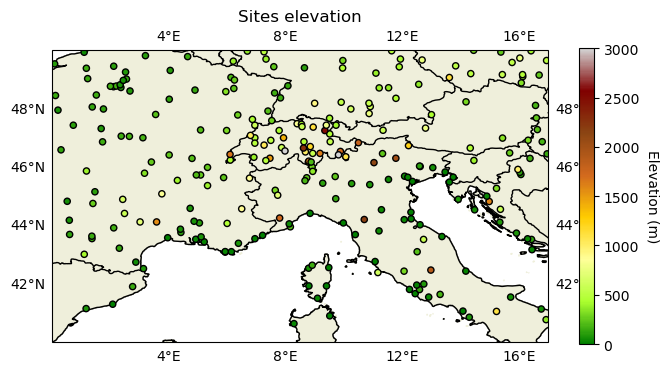

In [4]:
from matplotlib.colors import LinearSegmentedColormap

def filter_inconsistent_values(df):
    # Replace temperature values outside the range with NaN
    df['temperature'] = np.where((df['temperature'] < -100) | (df['temperature'] > 100), np.nan, df['temperature'])
    return df

# Apply the filtering to each DataFrame in all_dataframes
filtered_dataframes = [filter_inconsistent_values(df.copy()) for df in all_dataframes]

# Extract mean Tmax values and site coordinates
mean_tmax_values = [df['temperature'].mean() for df in filtered_dataframes]
site_lons = [df['lon'].iloc[0] if not df.empty else None for df in filtered_dataframes]
site_lats = [df['lat'].iloc[0] if not df.empty else None for df in filtered_dataframes]
site_elevations = [df['elevation'].iloc[0] if not df.empty else None for df in filtered_dataframes]


# Remove None values from site_lons and site_lats
#mean_tmax_values = [mean_tmax for mean_tmax, lon, lat in zip(mean_tmax_values, site_lons, site_lats) if lon is not None and lat is not None]
#site_lons = [lon for lon in site_lons if lon is not None]
#site_lats = [lat for lat in site_lats if lat is not None]

# Remove None values from site_lons, site_lats, and site_elevations
mean_tmax_values = [mean_tmax for mean_tmax, lon, lat, elevation in zip(mean_tmax_values, site_lons, site_lats, site_elevations) if lon is not None and lat is not None]
site_lons = [lon for lon in site_lons if lon is not None]
site_lats = [lat for lat in site_lats if lat is not None]
site_elevations = [elevation for elevation in site_elevations if elevation is not None]

# Create a map using Cartopy
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(zorder=0)
# Add land-sea mask first
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                         edgecolor='face', facecolor=cfeature.COLORS['land'])
ax.add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
ax.set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
 
# Add land and state borders
ax.add_feature(cfeature.BORDERS, linestyle='-', zorder=0)
ax.add_feature(cfeature.COASTLINE, zorder=0)

# Add lon/lat gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LongitudeFormatter(degree_symbol='°', dateline_direction_label=True)
gl.yformatter = LatitudeFormatter(degree_symbol='°')
# Set gridline intervals to every 2 degrees
gl.xlocator = plt.MaxNLocator(5)
gl.ylocator = plt.MaxNLocator(5)

# Create a custom colormap representing increasing elevation
colors = [(0, 0, 0.5), (0, 0.5, 1), (0, 1, 0.5), (1, 1, 0), (1, 0.5, 0), (1, 0, 0)]
colors = ['green', 'greenyellow','#FFFF99', '#FFCC00','chocolate',
                   'saddlebrown','maroon','lightgrey']
elevation_cmap = LinearSegmentedColormap.from_list('elevation', colors, N=256)


# Scatter plot of sites with mean Tmax values as colors
sc = ax.scatter(site_lons, site_lats, c=site_elevations, 
                cmap=elevation_cmap, s=20, edgecolors='k', vmin=0, vmax=3000)


# Add colorbar
cbar = plt.colorbar(sc, ax=ax, label='Elevation',shrink=.48)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)

# Add title and labels
plt.title('Sites elevation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.savefig('reference_sites_elevation.png',dpi=300)
plt.show()

### DAV

In [21]:
# Initialize lists to store values for each model
all_S_nonCP = []
all_S_CP = []
all_DAV = []
model_names = []

# Initialize DataFrames to store values for each model
df_S_nonCP = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)
df_S_CP = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)
df_DAV = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)

SIM_DIR_nonCP = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/FILES_nonCP/tasmax/historical'
SIM_DIR_CP = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/FILES_CP/tasmax/historical'

for i in range(0,len(MODELS)) : 
    
    if i == len(MODELS)-1: 
        file_path = os.path.join(f'{SIM_DIR_nonCP}/{filename_nonCP[8]}')
        print(f'{MODELS[8]} nonCP (II)')
    else : 
        file_path = os.path.join(f'{SIM_DIR_nonCP}/{filename_nonCP[i]}')
        print(f'{MODELS[i]} nonCP')
        
    nc = Dataset(file_path)
    lon_model = nc.variables['lon'][:]
    lat_model = nc.variables['lat'][:]
    tasmax = nc.variables['tasmax'][:]
    
    # Reference site coordinates
    reference_coords = list(zip(site_lons, site_lats))
    
    # Flatten the lat and lon arrays from the model data
    model_lon_flat = lon_model.flatten()
    model_lat_flat = lat_model.flatten()

    # Create a KDTree from the flattened lon and lat arrays
    tree = cKDTree(list(zip(model_lon_flat, model_lat_flat)))

    # Query the KDTree to find the nearest neighbors for each reference site
    nearest_indices = []

    for lon, lat in reference_coords:
        dist, idx = tree.query([lon, lat])
        
        # Check if the index is within bounds
        if 0 <= idx < len(model_lon_flat):
            nearest_indices.append(idx)
        else:
            # Handle the case when the index is out of bounds
            nearest_indices.append(np.nan)

    # Extract the lon and lat values for the nearest grid nodes
    nearest_lon = [model_lon_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]
    nearest_lat = [model_lat_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]

    # Reshape the tasmax_data variable to have a flattened lat and lon dimension
    tasmax_data_flat = tasmax.reshape(tasmax.shape[0], -1)

    # Initialize an empty list to store tasmax values for each reference site
    tasmax_values = []

    # Extract tasmax values for each reference site
    for idx in nearest_indices:
        if not np.isnan(idx):
            tasmax_values.append(tasmax_data_flat[:, int(idx)])
        else:
            # Handle the case when the index is NaN
            tasmax_values.append(np.full(tasmax.shape[0], np.nan))

    # Convert the list of tasmax values to a NumPy array
    tasmax_values_nonCP = np.array(tasmax_values)-273.16

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    
    del(tasmax_values)
    
    file_path = os.path.join(f'{SIM_DIR_CP}/{filename_CP[i]}')
        
    print(f'{MODELS[i]} CP')
        
    nc = Dataset(file_path)
    lon_model = nc.variables['lon'][:]
    lat_model = nc.variables['lat'][:]
    tasmax = nc.variables['tasmax'][:]
    
    # Reference site coordinates
    reference_coords = list(zip(site_lons, site_lats))
    
    # Flatten the lat and lon arrays from the model data
    model_lon_flat = lon_model.flatten()
    model_lat_flat = lat_model.flatten()

    # Create a KDTree from the flattened lon and lat arrays
    tree = cKDTree(list(zip(model_lon_flat, model_lat_flat)))

    # Query the KDTree to find the nearest neighbors for each reference site
    nearest_indices = []

    for lon, lat in reference_coords:
        dist, idx = tree.query([lon, lat])
        
        # Check if the index is within bounds
        if 0 <= idx < len(model_lon_flat):
            nearest_indices.append(idx)
        else:
            # Handle the case when the index is out of bounds
            nearest_indices.append(np.nan)

    # Extract the lon and lat values for the nearest grid nodes
    nearest_lon = [model_lon_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]
    nearest_lat = [model_lat_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]

    # Reshape the tasmax_data variable to have a flattened lat and lon dimension
    tasmax_data_flat = tasmax.reshape(tasmax.shape[0], -1)

    # Initialize an empty list to store tasmax values for each reference site
    tasmax_values = []

    # Extract tasmax values for each reference site
    for idx in nearest_indices:
        if not np.isnan(idx):
            tasmax_values.append(tasmax_data_flat[:, int(idx)])
        else:
            # Handle the case when the index is NaN
            tasmax_values.append(np.full(tasmax.shape[0], np.nan))

    # Convert the list of tasmax values to a NumPy array
    tasmax_values_CP = np.array(tasmax_values)-273.16

    
# # # #  # # # # # # # # # # # # # # # # # # # # # DAV # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

    DAV_sites=[]

    # Calculate the ECDF
    def ecdf(data):
        sorted_data = np.sort(data)
        n = len(data)
        y = np.arange(1, n + 1) / n
        return sorted_data, y
    
    # Assuming you have a counter defined somewhere
    counter = 0
    for j in range(0,len(site_lons)) : 

        observed_data = filtered_dataframes[j]['temperature']
        percentage_nan_values = observed_data.isnull().mean() * 100
       
        #Check if there are any non-null values
        #if not observed_data.isnull().all():
        if percentage_nan_values < 50:
        
            simulated_nonCP_data = tasmax_values_nonCP[j,:]
            simulated_CP_data = tasmax_values_CP[j,:]

            # Find temperature range on which computing ECDFs (1 bin = 1 °C)
            range_max = round(np.nanmax(observed_data))
            range_min = round(np.nanmin(observed_data))
            temperature_range = np.arange(range_min, range_max + 1)

            # Compute the ECDF
            x_sim_obs, f_sim_obs = ecdf(observed_data)
            x_sim_nonCP, f_sim_nonCP = ecdf(simulated_nonCP_data)
            x_sim_CP, f_sim_CP = ecdf(simulated_CP_data)

            # Create the histograms
            hist_obs, bins_obs = np.histogram(x_sim_obs, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1), weights=f_sim_obs, density=True)
            hist_nonCP, bins_nonCP = np.histogram(x_sim_nonCP, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1), weights=f_sim_nonCP, density=True)
            hist_CP, bins_CP = np.histogram(x_sim_CP, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1), weights=f_sim_CP, density=True)

            # For S_nonCP
            S_nonCP = np.sum(np.minimum(hist_nonCP, hist_obs))

            # For S_CP
            S_CP = np.sum(np.minimum(hist_CP, hist_obs))

            DAV = (S_CP - S_nonCP) / S_nonCP * 100 
            
            if S_nonCP == 0 and S_CP >= 1 :  
                DAV = 100
            elif S_nonCP == 0 and S_CP == 0 :  
                DAV = np.nan
            
        else: 
            DAV = np.nan 

        DAV_sites.append(DAV)  
        model_name=MODELS[i]

        # Fill DataFrame columns at each iteration
        df_S_nonCP.at[counter, model_name] = S_nonCP
        df_S_CP.at[counter, model_name] = S_CP
        df_DAV.at[counter, model_name] = DAV

        # Increment the counter for the next iteration
        counter += 1
        

BCCR-AUTH nonCP
BCCR-AUTH CP
BTU nonCP
BTU CP


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


CMCC nonCP
CMCC CP
CNRM nonCP
CNRM CP
ETHZ nonCP
ETHZ CP
FZJ-IDL nonCP
FZJ-IDL CP
HCLIM nonCP
HCLIM CP
ICTP nonCP
ICTP CP
KIT nonCP
KIT CP
KNMI nonCP
KNMI CP
UKMO nonCP
UKMO CP
KIT nonCP (II)
JLU CP


### Plot DAV

BCCR-AUTH done
BTU done
CMCC done
CNRM done
ETHZ done
FZJ-IDL done
HCLIM done
ICTP done
KIT done
KNMI done
UKMO done
JLU done
ENS done


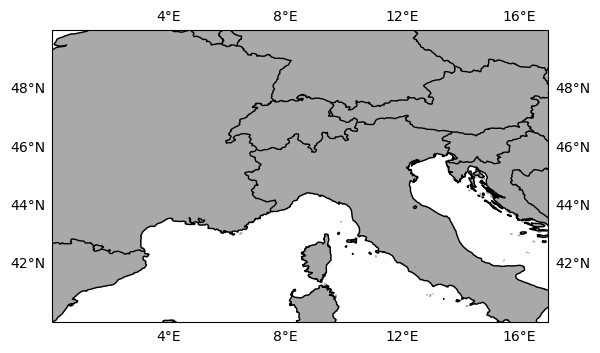

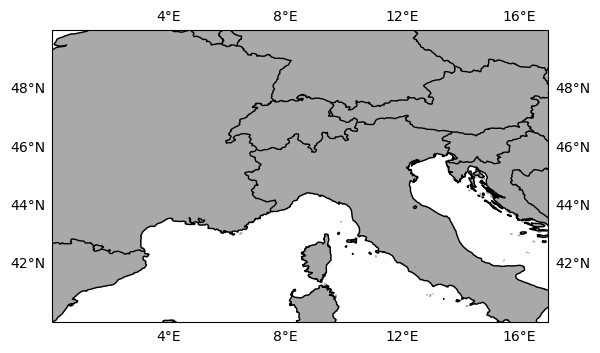

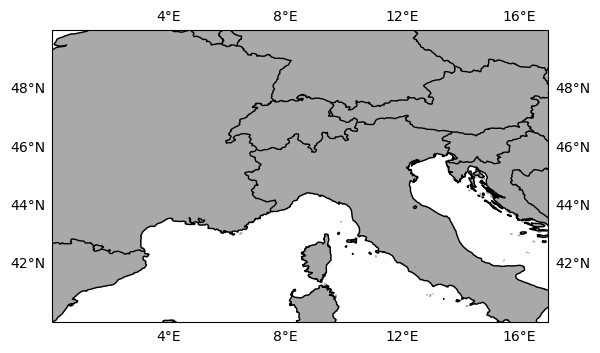

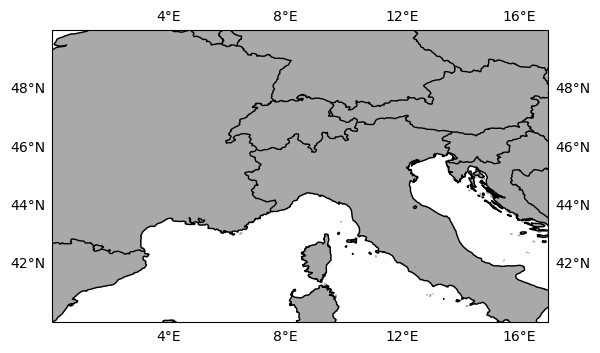

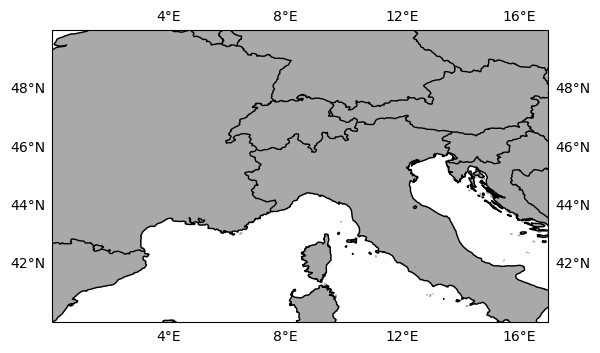

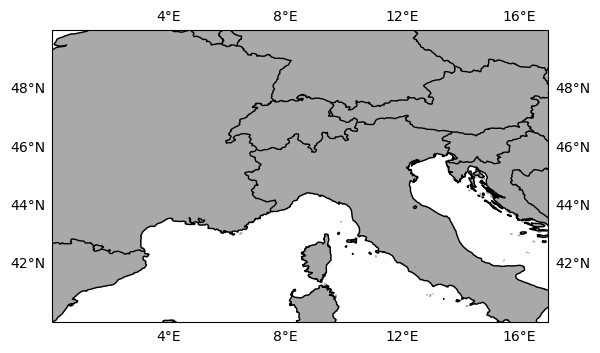

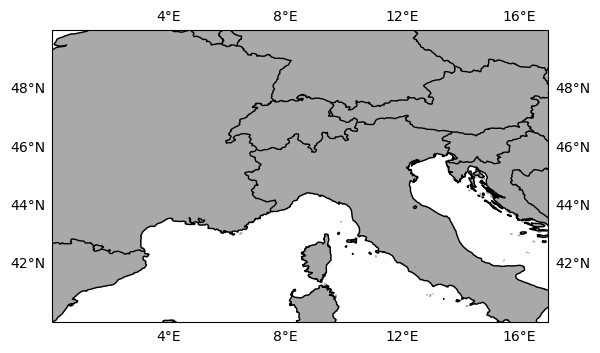

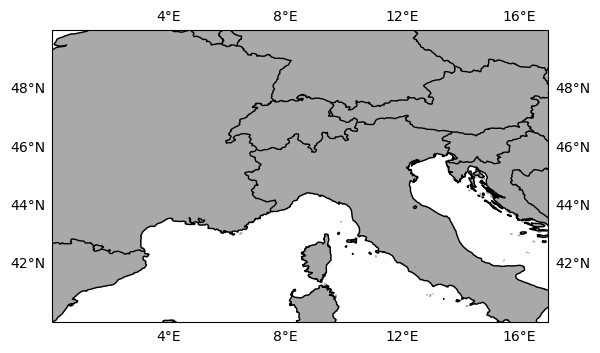

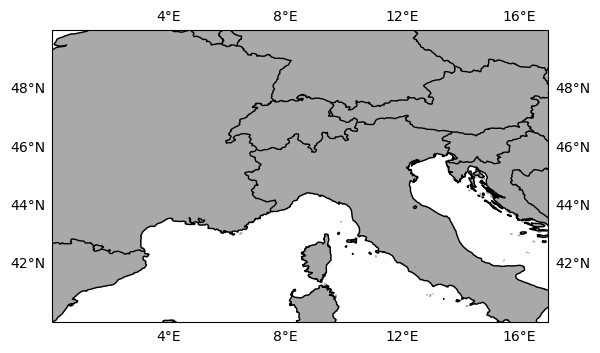

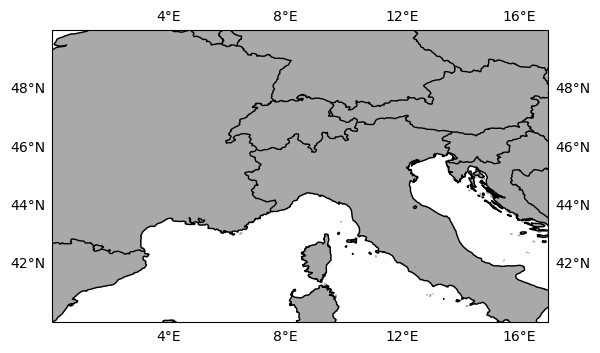

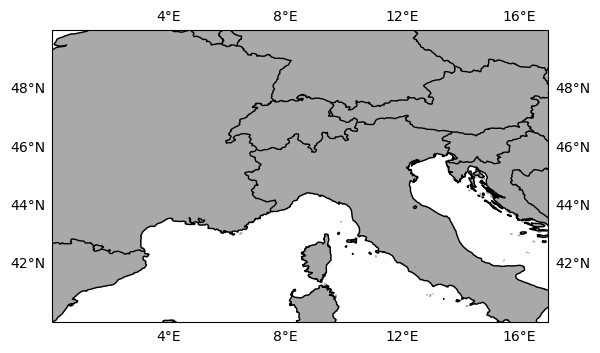

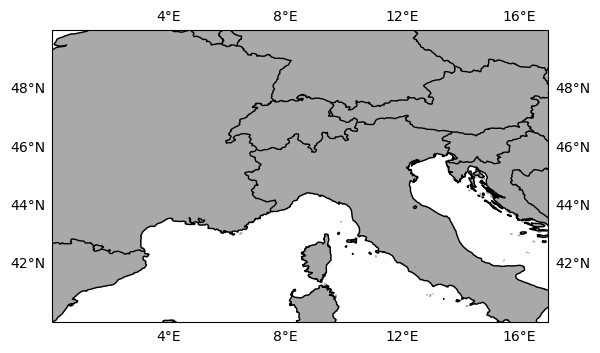

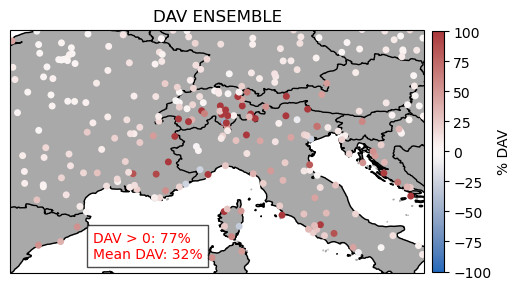

In [22]:

# Iterate over each model for scatterplots
for model_name in MODELS:
    # Select DAV values for the current model
    DAV_model = df_DAV[model_name]

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add land-sea mask first
    #land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land'])
    land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='darkgrey')
    ax.add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
    ax.set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
 
    # Add land and state borders
    ax.add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
    ax.add_feature(cfeature.COASTLINE,zorder=0)

    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=None)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LongitudeFormatter(degree_symbol='°', dateline_direction_label=True)
    gl.yformatter = LatitudeFormatter(degree_symbol='°')

    # Set gridline intervals to every 2 degrees
    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    
    # Scatter plot for DAV values without transparency
    #sc = ax.scatter(site_lons, site_lats, c=DAV_model,
    #                cmap=sns.color_palette("vlag", as_cmap=True), s=25, edgecolors='k', vmin=-100, vmax=100, alpha=1.0)
    
    # Add colorbar
    #cbar = plt.colorbar(sc, orientation='vertical', label='% DAV', shrink=0.65)

    #plt.title(f'DAV {model_name}')
    #plt.savefig(f'DAV_{model_name}.png')
    
    print(f'{model_name} done')
   
    
# Calculate ensemble mean across models
df_DAV['Ensemble_Mean'] = df_DAV[MODELS].mean(axis=1)
df_DAV['Ensemble_Mean'] = pd.to_numeric(df_DAV['Ensemble_Mean'], errors='coerce')

# Set values not finite to NaN
df_DAV['Ensemble_Mean'] = np.where(np.isfinite(df_DAV['Ensemble_Mean']), df_DAV['Ensemble_Mean'], np.nan)
df_DAV_all = df_DAV

# Calculate the percentage of sites with positive DAV
positive_dav_percentage_all = (df_DAV['Ensemble_Mean'] > 0).sum() / df_DAV['Ensemble_Mean'].notnull().sum() * 100
# Calculate overall mean DAV across all sites
mean_DAV_all_sites = np.nanmean(df_DAV['Ensemble_Mean'])


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# Create levels from -100 to 100 with step size of 10
levels = np.arange(-100, 110, 10)  # Levels from -100 to 100 with intervals of 10
# Create a norm to map values to the levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels)-1)

#ax.coastlines()
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='darkgrey')
ax.add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
ax.set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
ax.add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
ax.add_feature(cfeature.COASTLINE,zorder=0)

#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='-')
#gl.xlabels_top = False
gl.ylabels_right = False
#gl.xformatter = LongitudeFormatter(degree_symbol='°', dateline_direction_label=True)
#gl.yformatter = LatitudeFormatter(degree_symbol='°')
#gl.xlocator = plt.MaxNLocator(5)
#gl.ylocator = plt.MaxNLocator(5)

sc = ax.scatter(site_lons, site_lats, c=df_DAV['Ensemble_Mean'],
                cmap=sns.color_palette("vlag", as_cmap=True),
                s=25, edgecolors='none', vmin=-100, vmax=100, alpha=1)


cbar = plt.colorbar(sc, orientation='vertical', label='% DAV', shrink=0.65,pad=.015)

# Create a multiline text
info_text = f"DAV > 0: {positive_dav_percentage:.0f}%\nMean DAV: {mean_DAV_all_sites:.0f}%"
# Add the text to the lower-left part of the map
fig.text(0.2, 0.05, info_text, ha='left', va='bottom', transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='white', alpha=0.7),color='red')

plt.title(f'DAV ENSEMBLE')
plt.savefig(f'DAV_ENS.png',dpi=300)
print(f'ENS done')

### Violin plots

ValueError: cannot reindex on an axis with duplicate labels

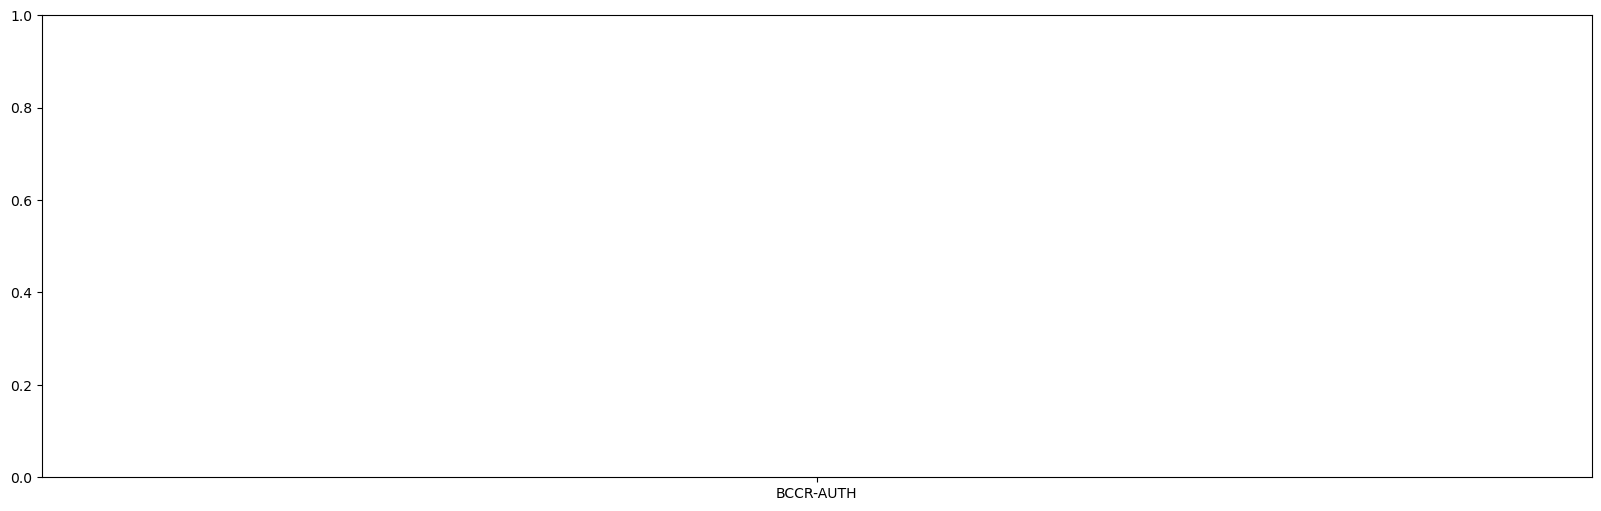

In [7]:
models_to_compare = ['BCCR-AUTH', 'BTU', 'CMCC', 'CNRM',
                     'ETHZ', 'FZJ-IDL', 'HCLIM', 'ICTP', 'KIT', 'KNMI', 'UKMO','JLU']

# Create a list to store the combined dataframes for each model
combined_dfs = []

# Iterate over the models and create the combined dataframe
for model_name in models_to_compare:
    # Extract data for the chosen model
    data_S_nonCP = df_S_nonCP[model_name]
    data_S_CP = df_S_CP[model_name]
    
    if model_name == 'JLU' : 
        data_S_nonCP = df_S_nonCP['KIT']
        data_S_CP = df_S_CP['JLU']
    
    # Convert the data to numeric, replacing non-numeric values with NaN
    data_S_nonCP = pd.to_numeric(data_S_nonCP, errors='coerce')
    data_S_CP = pd.to_numeric(data_S_CP, errors='coerce')

    # Create a DataFrame for the chosen model
    df_model_nonCP = pd.DataFrame({
        'Resolution': ['S-score RCM'] * len(data_S_nonCP),
        'Temperature': data_S_nonCP
    })

    df_model_CP = pd.DataFrame({
        'Resolution': ['S-score CPRCM'] * len(data_S_CP),
        'Temperature': data_S_CP
    })

    # Combine the dataframes for S_nonCP and S_CP for the current model
    df_combined_model = pd.concat([df_model_nonCP, df_model_CP])

    # Add the model name as a column
    df_combined_model['Model'] = model_name

    # Append the combined dataframe to the list
    combined_dfs.append(df_combined_model)

# Calculate ensemble mean for each resolution across all models
ensemble_mean_nonCP = df_S_nonCP[models_to_compare].mean(axis=1)
ensemble_mean_CP = df_S_CP[models_to_compare].mean(axis=1)

# Create a DataFrame for the ensemble means
df_ensemble_mean_nonCP = pd.DataFrame({
    'Resolution': ['S-score RCM'] * len(ensemble_mean_nonCP),
    'Temperature': ensemble_mean_nonCP,
    'Model': 'Ensemble Mean'
})

df_ensemble_mean_CP = pd.DataFrame({
    'Resolution': ['S-score CPRCM'] * len(ensemble_mean_CP),
    'Temperature': ensemble_mean_CP,
    'Model': 'Ensemble Mean'
})    
    
    
# Append the ensemble mean dataframes to the list
combined_dfs.extend([df_ensemble_mean_nonCP, df_ensemble_mean_CP])

# Combine all the dataframes into a single dataframe
df_combined = pd.concat(combined_dfs)   
    

# Create a split violin plot
plt.figure(figsize=(20, 6))
ax = sns.violinplot(data=df_combined, x="Model", y="Temperature", hue="Resolution", split=True, inner="quart", palette="muted")

ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)  # Adjust the font size for x-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)  # Adjust the font size for y-axis tick labelsplt.title('S score')

# Add grid
ax.yaxis.grid(True,linewidth=.2)

plt.xlabel('Model', fontsize=16)
plt.ylabel('S score', fontsize=16)
plt.legend(loc='upper right',fontsize=14)
plt.savefig('violin.png',dpi=300)



### DAV over the 90th percentile 

In [23]:
# Initialize lists to store values for each model
all_S_nonCP = []
all_S_CP = []
all_DAV = []
model_names = []

# Initialize DataFrames to store values for each model
df_S_nonCP = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)
df_S_CP = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)
df_DAV = pd.DataFrame(index=range(0,len(site_lons)), columns=MODELS)

SIM_DIR_nonCP = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/FILES_nonCP/tasmax/historical'
SIM_DIR_CP = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/FILES_CP/tasmax/historical'

for i in range(0,len(MODELS)) : 
    
    
    if i == len(MODELS)-1: 
        file_path = os.path.join(f'{SIM_DIR_nonCP}/{filename_nonCP[8]}')
        print(f'{MODELS[8]} nonCP (II)')
    else : 
        file_path = os.path.join(f'{SIM_DIR_nonCP}/{filename_nonCP[i]}')
        print(f'{MODELS[i]} nonCP')
        
    nc = Dataset(file_path)
    lon_model = nc.variables['lon'][:]
    lat_model = nc.variables['lat'][:]
    tasmax = nc.variables['tasmax'][:]
    
    # Reference site coordinates
    reference_coords = list(zip(site_lons, site_lats))
    
    # Flatten the lat and lon arrays from the model data
    model_lon_flat = lon_model.flatten()
    model_lat_flat = lat_model.flatten()

    # Create a KDTree from the flattened lon and lat arrays
    tree = cKDTree(list(zip(model_lon_flat, model_lat_flat)))

    # Query the KDTree to find the nearest neighbors for each reference site
    nearest_indices = []

    for lon, lat in reference_coords:
        dist, idx = tree.query([lon, lat])
        
        # Check if the index is within bounds
        if 0 <= idx < len(model_lon_flat):
            nearest_indices.append(idx)
        else:
            # Handle the case when the index is out of bounds
            nearest_indices.append(np.nan)

    # Extract the lon and lat values for the nearest grid nodes
    nearest_lon = [model_lon_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]
    nearest_lat = [model_lat_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]

    # Reshape the tasmax_data variable to have a flattened lat and lon dimension
    tasmax_data_flat = tasmax.reshape(tasmax.shape[0], -1)

    # Initialize an empty list to store tasmax values for each reference site
    tasmax_values = []

    # Extract tasmax values for each reference site
    for idx in nearest_indices:
        if not np.isnan(idx):
            tasmax_values.append(tasmax_data_flat[:, int(idx)])
        else:
            # Handle the case when the index is NaN
            tasmax_values.append(np.full(tasmax.shape[0], np.nan))

    # Convert the list of tasmax values to a NumPy array
    tasmax_values_nonCP = np.array(tasmax_values)-273.16

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    
    del(tasmax_values)
    
    file_path = os.path.join(f'{SIM_DIR_CP}/{filename_CP[i]}')
        
    print(f'{MODELS[i]} CP')
        
    nc = Dataset(file_path)
    lon_model = nc.variables['lon'][:]
    lat_model = nc.variables['lat'][:]
    tasmax = nc.variables['tasmax'][:]
    
    # Reference site coordinates
    reference_coords = list(zip(site_lons, site_lats))
    
    # Flatten the lat and lon arrays from the model data
    model_lon_flat = lon_model.flatten()
    model_lat_flat = lat_model.flatten()

    # Create a KDTree from the flattened lon and lat arrays
    tree = cKDTree(list(zip(model_lon_flat, model_lat_flat)))

    # Query the KDTree to find the nearest neighbors for each reference site
    nearest_indices = []

    for lon, lat in reference_coords:
        dist, idx = tree.query([lon, lat])
        
        # Check if the index is within bounds
        if 0 <= idx < len(model_lon_flat):
            nearest_indices.append(idx)
        else:
            # Handle the case when the index is out of bounds
            nearest_indices.append(np.nan)

    # Extract the lon and lat values for the nearest grid nodes
    nearest_lon = [model_lon_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]
    nearest_lat = [model_lat_flat[int(idx)] if not np.isnan(idx) else np.nan for idx in nearest_indices]

    # Reshape the tasmax_data variable to have a flattened lat and lon dimension
    tasmax_data_flat = tasmax.reshape(tasmax.shape[0], -1)

    # Initialize an empty list to store tasmax values for each reference site
    tasmax_values = []

    # Extract tasmax values for each reference site
    for idx in nearest_indices:
        if not np.isnan(idx):
            tasmax_values.append(tasmax_data_flat[:, int(idx)])
        else:
            # Handle the case when the index is NaN
            tasmax_values.append(np.full(tasmax.shape[0], np.nan))

    # Convert the list of tasmax values to a NumPy array
    tasmax_values_CP = np.array(tasmax_values)-273.16

    
# # # #  # # # # # # # # # # # # # # # # # # # # # DAV # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

    DAV_sites=[]

    # Calculate the ECDF
    def ecdf(data):
        sorted_data = np.sort(data)
        n = len(data)
        y = np.arange(1, n + 1) / n
        return sorted_data, y
    
    counter = 0
    for j in range(0, len(site_lons)):
        
        observed_data = filtered_dataframes[j]['temperature']
        
        # Check if there are any non-null values
        if not observed_data.isnull().all():
            simulated_nonCP_data = tasmax_values_nonCP[j, :]
            simulated_CP_data = tasmax_values_CP[j, :]
            
            # Calculate the 90th percentile
            p90_obs   = np.nanpercentile(observed_data, 90)
            p90_nonCP = np.nanpercentile(simulated_nonCP_data, 90)
            p90_CP    = np.nanpercentile(simulated_CP_data, 90)
            
            # Filter values above the 90th percentile
            obs_above_90   = observed_data[observed_data >= p90_obs]
            nonCP_above_90 = simulated_nonCP_data[simulated_nonCP_data >= p90_nonCP]
            CP_above_90    = simulated_CP_data[simulated_CP_data >= p90_CP]
            
            # Find temperature range on which computing ECDFs (1 bin = 1 °C)
            range_max = round(np.nanmax(obs_above_90))
            range_min = round(np.nanmin(obs_above_90))
            temperature_range = np.arange(range_min, range_max + 1)
            
            # Compute the ECDF
            x_obs, f_obs = ecdf(obs_above_90)
            x_nonCP, f_nonCP = ecdf(nonCP_above_90)
            x_CP, f_CP = ecdf(CP_above_90)
            
            # Create the histograms for filtered data
            hist_obs, bins_obs = np.histogram(x_obs, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1),
                                               weights=f_obs, density=True)
            hist_nonCP, bins_nonCP = np.histogram(x_nonCP, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1),
                                              weights=f_nonCP, density=True)
            hist_CP, bins_CP = np.histogram(x_CP, bins=np.arange(temperature_range[0], temperature_range[-1] + 1, 1),
                                        weights=f_CP, density=True)
            
            # For S_nonCP
            S_nonCP = np.sum(np.minimum(hist_nonCP, hist_obs))

            # For S_CP
            S_CP = np.sum(np.minimum(hist_CP, hist_obs))

            DAV = (S_CP - S_nonCP) / S_nonCP * 100 
            
            if S_nonCP == 0 and S_CP >= 1 :  
                DAV = 100
            elif S_nonCP == 0 and S_CP == 0 :  
                DAV = np.nan
            
        else: 
            DAV = np.nan 

        DAV_sites.append(DAV)  
        model_name=MODELS[i]

        # Fill DataFrame columns at each iteration
        df_S_nonCP.at[counter, model_name] = S_nonCP
        df_S_CP.at[counter, model_name] = S_CP
        df_DAV.at[counter, model_name] = DAV

        # Increment the counter for the next iteration
        counter += 1
        

BCCR-AUTH nonCP
BCCR-AUTH CP


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_1798495/2208956684.py:187: RuntimeWarning: invalid value encountered in double_scalars
  DAV = (S_CP - S_nonCP) / S_nonCP * 100


BTU nonCP
BTU CP
CMCC nonCP
CMCC CP
CNRM nonCP
CNRM CP
ETHZ nonCP
ETHZ CP
FZJ-IDL nonCP
FZJ-IDL CP
HCLIM nonCP
HCLIM CP
ICTP nonCP
ICTP CP
KIT nonCP
KIT CP
KNMI nonCP
KNMI CP
UKMO nonCP
UKMO CP
KIT nonCP (II)
JLU CP


### Plot DAV over the 90th percentile 

BCCR-AUTH done
BTU done
CMCC done
CNRM done
ETHZ done
FZJ-IDL done
HCLIM done
ICTP done
KIT done
KNMI done
UKMO done
JLU done
ENS done


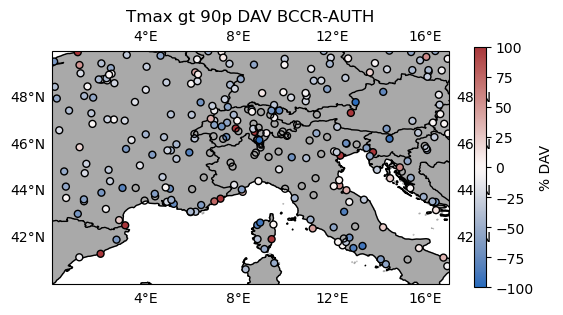

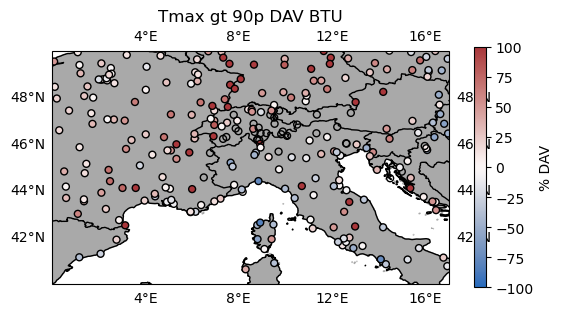

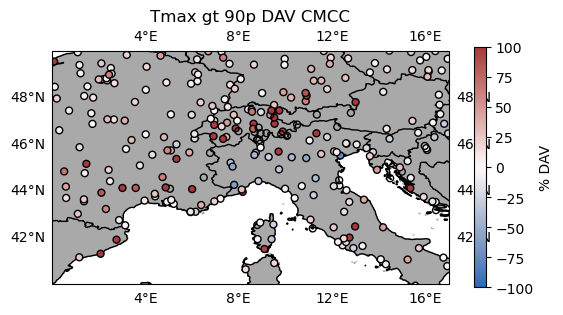

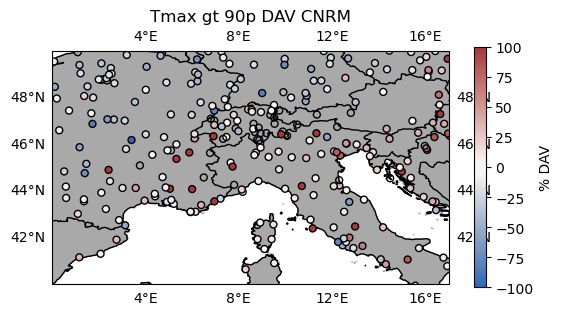

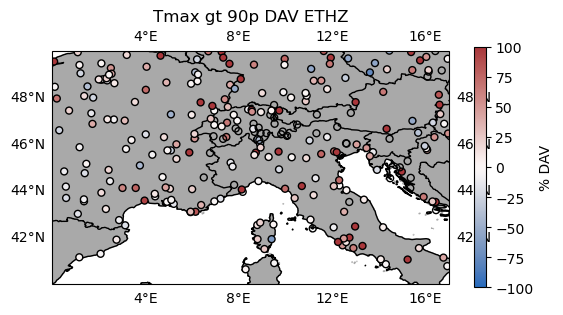

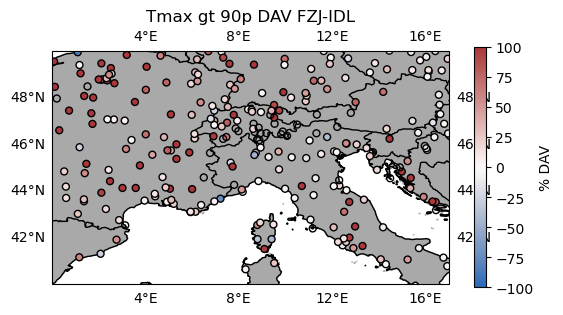

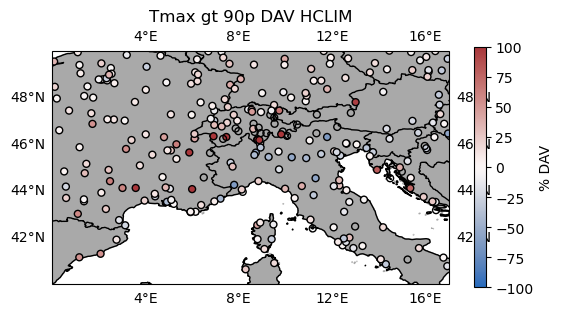

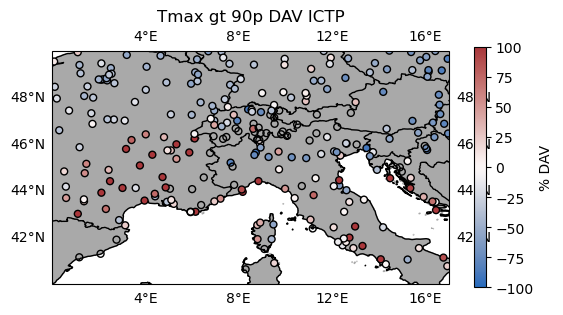

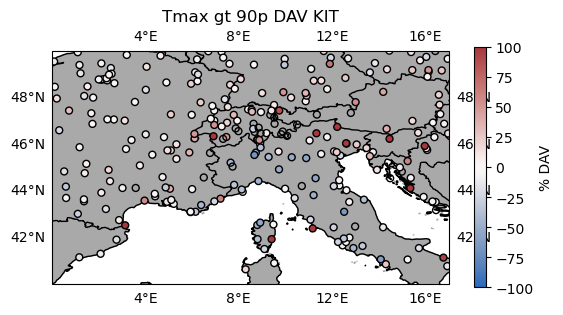

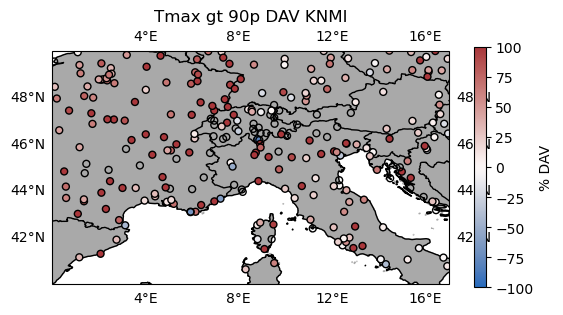

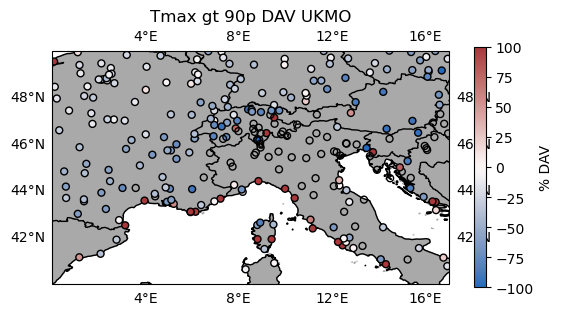

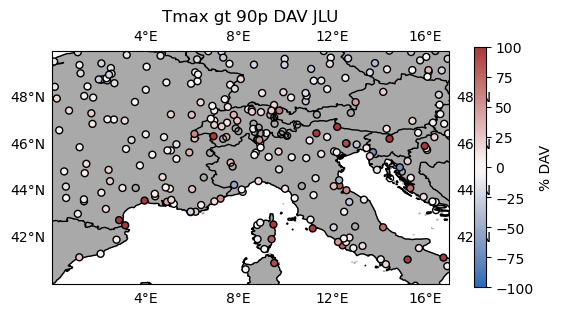

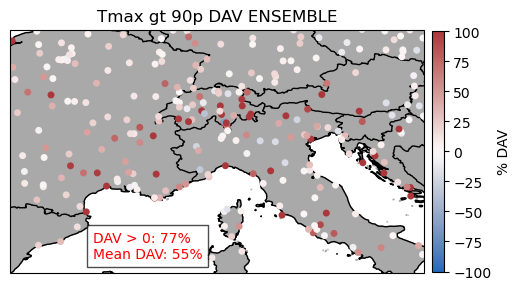

In [24]:
# Iterate over each model for scatterplots
for model_name in MODELS:
    # Select DAV values for the current model
    DAV_model = df_DAV[model_name]

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add land-sea mask first
    #land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor=cfeature.COLORS['land'])
    land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='darkgrey')
    ax.add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
    ax.set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
 
    # Add land and state borders
    ax.add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
    ax.add_feature(cfeature.COASTLINE,zorder=0)

    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=None)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LongitudeFormatter(degree_symbol='°', dateline_direction_label=True)
    gl.yformatter = LatitudeFormatter(degree_symbol='°')

    # Set gridline intervals to every 2 degrees
    gl.xlocator = plt.MaxNLocator(5)
    gl.ylocator = plt.MaxNLocator(5)
    
    # Scatter plot for DAV values without transparency
    sc = ax.scatter(site_lons, site_lats, c=DAV_model,
                    cmap=sns.color_palette("vlag", as_cmap=True), s=25,
                    edgecolors='k', vmin=-100, vmax=100, alpha=1.0)
    
    # Add colorbar
    cbar = plt.colorbar(sc, orientation='vertical', label='% DAV', shrink=0.65)

    plt.title(f'Tmax gt 90p DAV {model_name}')
    #plt.savefig(f'DAV_{model_name}_lt90p.png')
    
    print(f'{model_name} done')
   
    
# Calculate ensemble mean across models
df_DAV['Ensemble_Mean'] = df_DAV[MODELS].mean(axis=1)
df_DAV['Ensemble_Mean'] = pd.to_numeric(df_DAV['Ensemble_Mean'], errors='coerce')

# Set values not finite to NaN
df_DAV['Ensemble_Mean'] = np.where(np.isfinite(df_DAV['Ensemble_Mean']), df_DAV['Ensemble_Mean'], np.nan)
df_DAV_90p=df_DAV

# Calculate the percentage of sites with positive DAV
positive_dav_percentage_90p = (df_DAV_90p['Ensemble_Mean'] > 0).sum() / df_DAV_90p['Ensemble_Mean'].notnull().sum() * 100
# Calculate overall mean DAV across all sites
mean_DAV_all_sites_90p = np.nanmean(df_DAV_90p['Ensemble_Mean'])


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='darkgrey')
ax.add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
ax.set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
ax.add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
ax.add_feature(cfeature.COASTLINE,zorder=0)

#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='-')
#gl.xlabels_top = False
#gl.ylabels_right = False
#gl.xformatter = LongitudeFormatter(degree_symbol='°', dateline_direction_label=True)
#gl.yformatter = LatitudeFormatter(degree_symbol='°')
#gl.xlocator = plt.MaxNLocator(5)
#gl.ylocator = plt.MaxNLocator(5)

sc = ax.scatter(site_lons, site_lats, c=df_DAV_90p['Ensemble_Mean'],
                cmap=sns.color_palette("vlag", as_cmap=True),
                s=25, edgecolors='none', vmin=-100, vmax=100, alpha=1)

cbar = plt.colorbar(sc, orientation='vertical', label='% DAV', shrink=0.65,pad=.015)

# Create a multiline text
info_text = f"DAV > 0: {positive_dav_percentage:.0f}%\nMean DAV: {mean_DAV_all_sites_90p:.0f}%"
# Add the text to the lower-left part of the map
fig.text(0.2, 0.05, info_text, ha='left', va='bottom', transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='white', alpha=0.7),color='red')

plt.title(f'Tmax gt 90p DAV ENSEMBLE')
plt.savefig(f'DAV_ENS_lt90p.png',dpi=300)
print(f'ENS done')

### Plot DAV and DAV 90p on thesame plot 

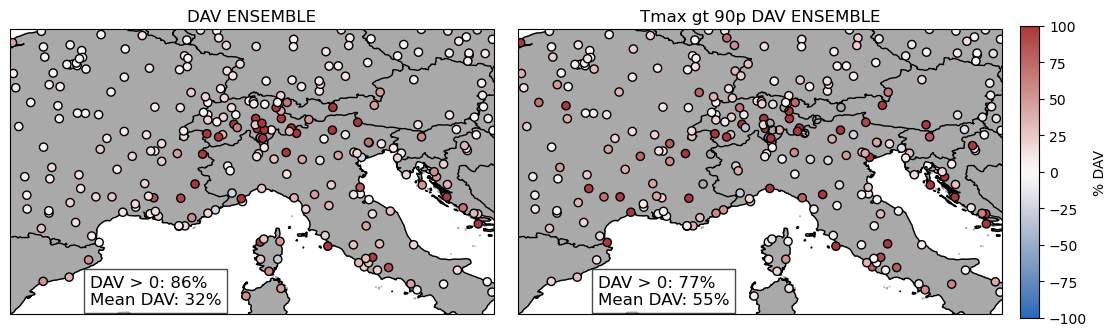

In [46]:
# Create a multiline text
info_text_all = f"DAV > 0: {positive_dav_percentage_all:.0f}%\nMean DAV: {mean_DAV_all_sites:.0f}%"
info_text_90p = f"DAV > 0: {positive_dav_percentage_90p:.0f}%\nMean DAV: {mean_DAV_all_sites_90p:.0f}%"

#fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})


land_mask = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='darkgrey')



P1 = axes[0].scatter(site_lons, site_lats, c=df_DAV_all['Ensemble_Mean'],
                cmap=sns.color_palette("vlag", as_cmap=True),
                s=35, edgecolors='k', vmin=-100, vmax=100, alpha=1)

P2 = axes[1].scatter(site_lons, site_lats, c=df_DAV_90p['Ensemble_Mean'],
                cmap=sns.color_palette("vlag", as_cmap=True),
                s=35, edgecolors='k', vmin=-100, vmax=100, alpha=1)


axes[0].add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
axes[0].set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
axes[0].add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
axes[0].add_feature(cfeature.COASTLINE,zorder=0)
axes[0].set_title(f'DAV ENSEMBLE',fontsize=12)
axes[0].text(2.8,40.35,info_text_all,fontsize=12,backgroundcolor='w',alpha=1,bbox=dict(facecolor='white', alpha=0.7))


axes[1].add_feature(land_mask, zorder=0)  # Set zorder to 0 to ensure it's plotted below the scatter points
axes[1].set_extent([lon_range.start, 17, lat_range.start, lat_range.stop])  # Limit to 17 degrees west
axes[1].add_feature(cfeature.BORDERS, linestyle='-',zorder=0)
axes[1].add_feature(cfeature.COASTLINE,zorder=0)
axes[1].set_title(f'Tmax gt 90p DAV ENSEMBLE',fontsize=12)
axes[1].text(2.8,40.35,info_text_90p,fontsize=12,backgroundcolor='w',alpha=1,bbox=dict(facecolor='white', alpha=0.7))

#cbar = plt.colorbar(P2,ax=(axes[0],axes[1]),orientation='vertical', label='% DAV', shrink=.45,pad=.015)

fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',label='% DAV',aspect=15,shrink=.45,pad=.015)

# Add the text to the lower-left part of the map
#fig.text(1.2, 0.10, info_text, ha='left', va='bottom', transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='white', alpha=0.7),color='red')


plt.savefig(f'DAV_ENS_all_and_90p.png',dpi=300)
#print(f'ENS done')

### Violin plot

/tmp/ipykernel_33317/2931715219.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the font size for y-axis tick labelsplt.title('S score')
/tmp/ipykernel_33317/2931715219.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the font size for y-axis tick labelsplt.title('S score')


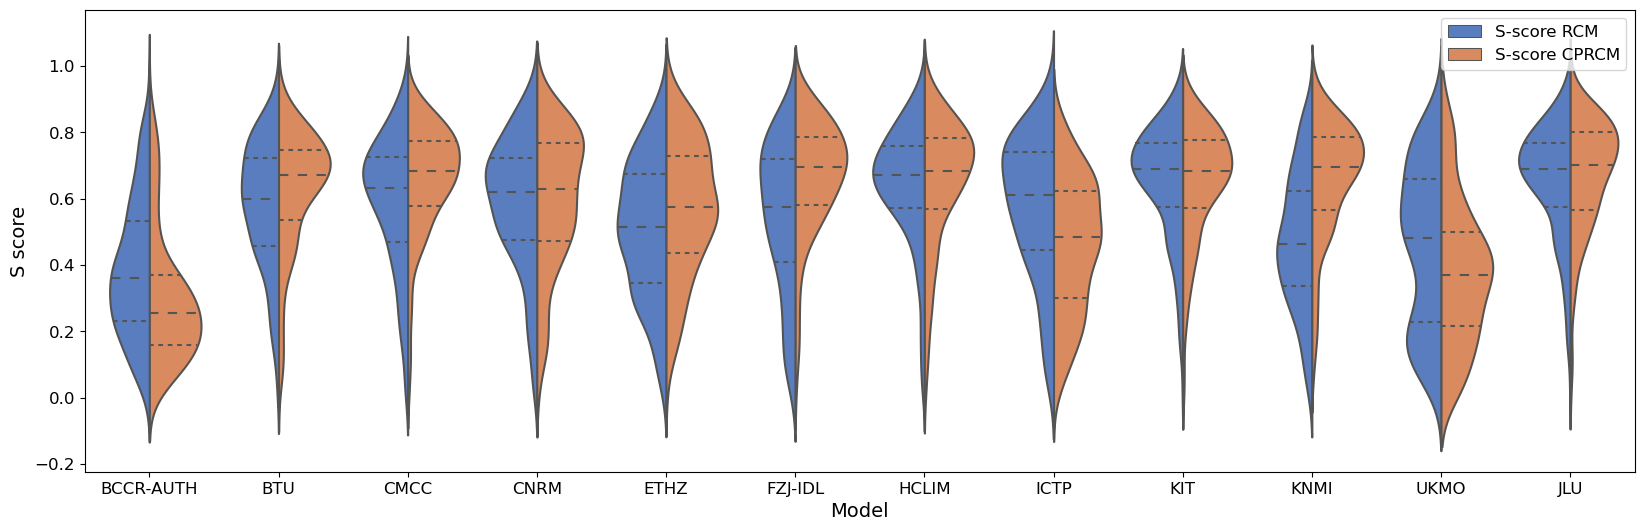

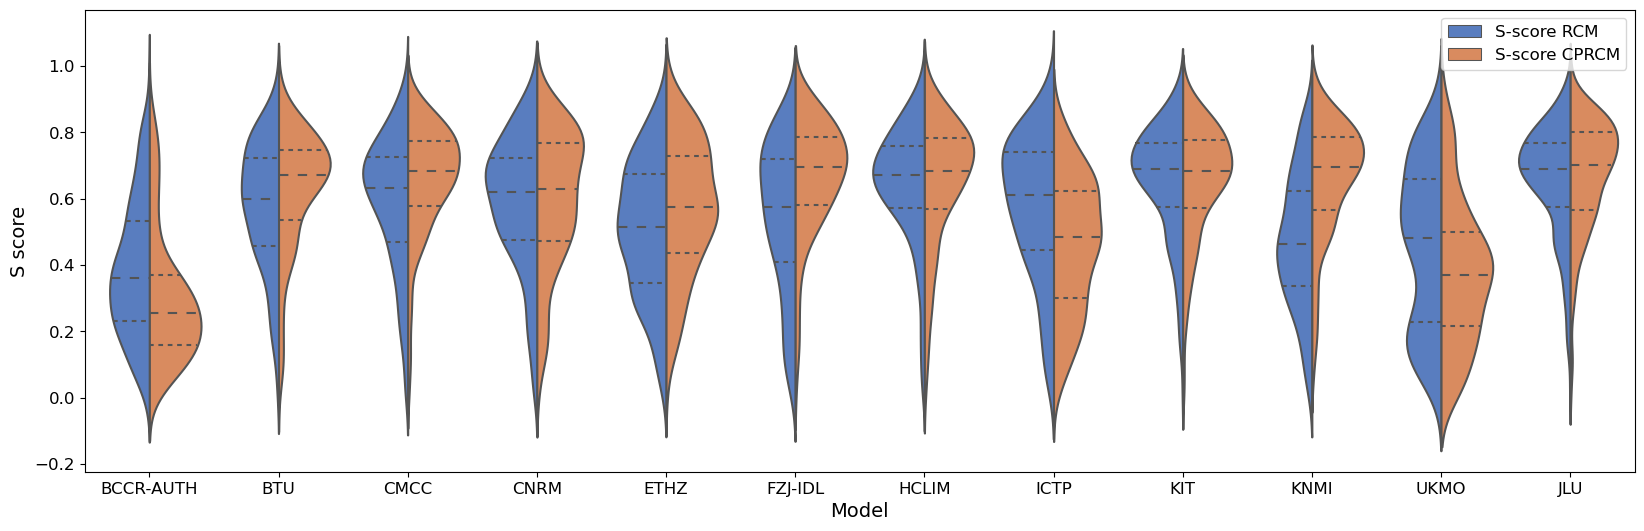

In [19]:
models_to_compare = ['BCCR-AUTH', 'BTU', 'CMCC', 'CNRM',
                     'ETHZ', 'FZJ-IDL', 'HCLIM', 'ICTP', 'KIT', 'KNMI', 'UKMO','JLU']

# Create a list to store the combined dataframes for each model
combined_dfs = []

# Iterate over the models and create the combined dataframe
for model_name in models_to_compare:
    # Extract data for the chosen model
    data_S_nonCP = df_S_nonCP[model_name]
    data_S_CP = df_S_CP[model_name]
    
    if model_name == 'JLU' : 
        data_S_nonCP = df_S_nonCP['KIT']
        data_S_CP = df_S_CP['JLU']
    
    # Convert the data to numeric, replacing non-numeric values with NaN
    data_S_nonCP = pd.to_numeric(data_S_nonCP, errors='coerce')
    data_S_CP = pd.to_numeric(data_S_CP, errors='coerce')

    # Create a DataFrame for the chosen model
    df_model_nonCP = pd.DataFrame({
        'Resolution': ['S-score RCM'] * len(data_S_nonCP),
        'Temperature': data_S_nonCP
    })

    df_model_CP = pd.DataFrame({
        'Resolution': ['S-score CPRCM'] * len(data_S_CP),
        'Temperature': data_S_CP
    })

    # Combine the dataframes for S_nonCP and S_CP for the current model
    df_combinedmodels_to_compare = ['BCCR-AUTH', 'BTU', 'CMCC', 'CNRM',
                     'ETHZ', 'FZJ-IDL', 'HCLIM', 'ICTP', 'KIT', 'KNMI', 'UKMO','JLU']

# Create a list to store the combined dataframes for each model
combined_dfs = []

# Iterate over the models and create the combined dataframe
for model_name in models_to_compare:
    # Extract data for the chosen model
    data_S_nonCP = df_S_nonCP[model_name]
    data_S_CP = df_S_CP[model_name]
    
    if model_name == 'JLU' : 
        data_S_nonCP = df_S_nonCP['KIT']
        data_S_CP = df_S_CP['JLU']
    
    # Convert the data to numeric, replacing non-numeric values with NaN
    data_S_nonCP = pd.to_numeric(data_S_nonCP, errors='coerce')
    data_S_CP = pd.to_numeric(data_S_CP, errors='coerce')

    # Create a DataFrame for the chosen model
    df_model_nonCP = pd.DataFrame({
        'Resolution': ['S-score RCM'] * len(data_S_nonCP),
        'Temperature': data_S_nonCP
    })

    df_model_CP = pd.DataFrame({
        'Resolution': ['S-score CPRCM'] * len(data_S_CP),
        'Temperature': data_S_CP
    })

    # Combine the dataframes for S_nonCP and S_CP for the current model
    df_combined_model = pd.concat([df_model_nonCP, df_model_CP])

    # Add the model name as a column
    df_combined_model['Model'] = model_name

    # Append the combined dataframe to the list
    combined_dfs.append(df_combined_model)

# Combine all the dataframes into a single dataframe
df_combined = pd.concat(combined_dfs)

# Create a split violin plot
plt.figure(figsize=(20, 6))
ax = sns.violinplot(data=df_combined, x="Model", y="Temperature", hue="Resolution", split=True, inner="quart", palette="muted")

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust the font size for x-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the font size for y-axis tick labelsplt.title('S score')

plt.xlabel('Model', fontsize=14)
plt.ylabel('S score', fontsize=14)
plt.legend(loc='upper right',fontsize=12)
plt.savefig('violin.png')


_model = pd.concat([df_model_nonCP, df_model_CP])

# Add the model name as a column
df_combined_model['Model'] = model_name

# Append the combined dataframe to the list
combined_dfs.append(df_combined_model)

# Combine all the dataframes into a single dataframe
df_combined = pd.concat(combined_dfs)

# Create a split violin plot
plt.figure(figsize=(20, 6))
ax = sns.violinplot(data=df_combined, x="Model", y="Temperature", hue="Resolution", split=True, inner="quart", palette="muted")

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)  # Adjust the font size for x-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)  # Adjust the font size for y-axis tick labelsplt.title('S score')

plt.xlabel('Model', fontsize=14)
plt.ylabel('S score', fontsize=14)
plt.legend(loc='upper right',fontsize=12)
plt.savefig('violin_above90p.png',dpi=300)

